# Convert Yolo V7 to ONNX and OpenVINO™ IR

This short tutorial demonstrates step-by-step instruction how to convert Pytorch Yolo V7 to OpenVINO IR. 

This tutorial consists of the following steps:
- Prepare PyTorch model
- Download and prepare dataset
- Validate original model
- Convert PyTorch model to ONNX
- Convert ONNX model to OpenVINO IR
- Validate converted model
- Prepare and run optimization pipeline
- Compare accuracy of the FP32 and quantized models.
- Compare performance of the FP32 and quantized models.

## Get Pytorch model

Generally, PyTorch model represents instance of torch.nn.Module class, iniatilized by state dictionary with model weights.
We will use YOLOv7 tiny model pretrained on COCO dataset, which available in this [repo](https://github.com/WongKinYiu/yolov7).
Typical steps for getting pretrained model:
1. Create instance of model class
2. Load checkpoint state dict, which contains pretrained model weights
3. Turn model to evaluation for switching some operations to inference mode

In our case, model authors already provide tool which allow to convert model to ONNX, so it is not necessary to do these steps manually.

## Prerequisites

In [1]:
import sys
from pathlib import Path

sys.path.append("../../utils")
from notebook_utils import download_file

c:\Users\eaidova\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\eaidova\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\eaidova\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Download YOLOv7 code
!git clone https://github.com/WongKinYiu/yolov7
%cd yolov7

c:\Users\eaidova\repos\openvino_notebooks\notebooks\102-pytorch-onnx-to-openvino\1021-vision-detection-yolov7\yolov7


fatal: destination path 'yolov7' already exists and is not an empty directory.


In [3]:
# Download pretrained model weights
MODEL_LINK = "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-tiny.pt"
DATA_DIR = Path("data/")
MODEL_DIR = Path("model/")
MODEL_DIR.mkdir(exist_ok=True)
DATA_DIR.mkdir(exist_ok=True)

download_file(MODEL_LINK, directory=MODEL_DIR, show_progress=True)

'model\yolov7-tiny.pt' already exists.


WindowsPath('C:/Users/eaidova/repos/openvino_notebooks/notebooks/102-pytorch-onnx-to-openvino/1021-vision-detection-yolov7/yolov7/model/yolov7-tiny.pt')

## Check model inference

In [4]:
!python detect.py --weights model/yolov7-tiny.pt --conf 0.25 --img-size 640 --source inference/images/horses.jpg

Namespace(weights=['model/yolov7-tiny.pt'], source='inference/images/horses.jpg', img_size=640, conf_thres=0.25, iou_thres=0.45, device='', view_img=False, save_txt=False, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False, no_trace=False)
Fusing layers... 
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

5 horses, Done. (719.8ms) Inference, (3.0ms) NMS
 The image with the result is saved in: runs\detect\exp2\horses.jpg
Done. (0.812s)


c:\Users\eaidova\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\eaidova\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\eaidova\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
YOLOR  v0.1-115-g072f76c torch 1.11.0+cpu CPU

Model Summary: 200 layers, 6219709 parameters, 229245 gradients
c:\Users\eaidova\Anaconda3\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


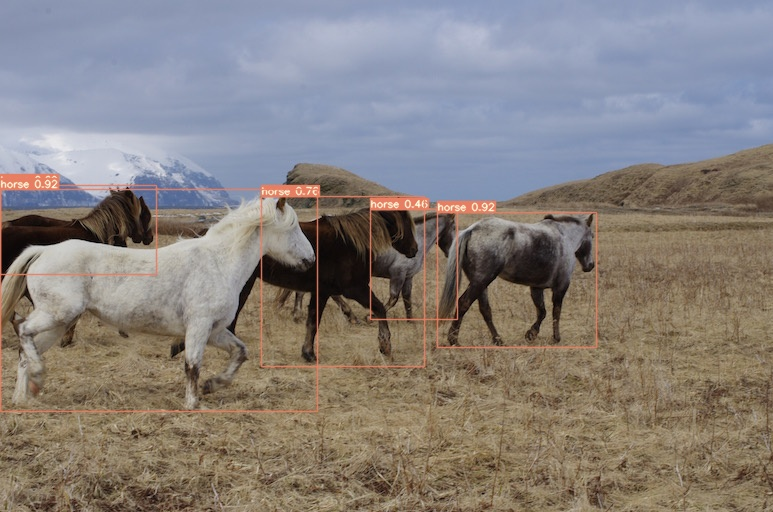

In [5]:
from PIL import Image
Image.open('runs/detect/exp/horses.jpg')

## Export to ONNX

In order to obtain ONNX model, we will use `export.py` script. Let's check it's arguments.

In [6]:
!python export.py --help

Import onnx_graphsurgeon failure: No module named 'onnx_graphsurgeon'
usage: export.py [-h] [--weights WEIGHTS] [--img-size IMG_SIZE [IMG_SIZE ...]]
                 [--batch-size BATCH_SIZE] [--dynamic] [--dynamic-batch]


c:\Users\eaidova\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\eaidova\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\eaidova\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


                 [--grid] [--end2end] [--max-wh MAX_WH] [--topk-all TOPK_ALL]
                 [--iou-thres IOU_THRES] [--conf-thres CONF_THRES]
                 [--device DEVICE] [--simplify] [--include-nms] [--fp16]
                 [--int8]

optional arguments:
  -h, --help            show this help message and exit
  --weights WEIGHTS     weights path
  --img-size IMG_SIZE [IMG_SIZE ...]
                        image size
  --batch-size BATCH_SIZE
                        batch size
  --dynamic             dynamic ONNX axes
  --dynamic-batch       dynamic batch onnx for tensorrt and onnx-runtime
  --grid                export Detect() layer grid
  --end2end             export end2end onnx
  --max-wh MAX_WH       None for tensorrt nms, int value for onnx-runtime nms
  --topk-all TOPK_ALL   topk objects for every images
  --iou-thres IOU_THRES
                        iou threshold for NMS
  --conf-thres CONF_THRES
                        conf threshold for NMS
  --device DEVICE       

The most important parameters:
* `--weights` - path to model weigths checkpoint
* `--img-size` - size of input image for onnx tracing

As ONNX is less flexible format then PyTorch, there is also opportunity to setup configurable parameters for results postprocessing included in model:
* `--end2end` - export full model to onnx including postporcessing
* `--grid` - export Detect layer as part of model
* `--topk-all` - topk elements for all images
* `--iou-thres` - intersection over union threshold for NMS
* `--conf-thres` - minimal confidence threshold
* `--max-wh` - max bounding box width and height for NMS

In [7]:
!python export.py --weights model/yolov7-tiny.pt \
        --grid --end2end --simplify \
        --topk-all 100 --iou-thres 0.65 --conf-thres 0.35 \
        --img-size 640 640 --max-wh 640

Import onnx_graphsurgeon failure: No module named 'onnx_graphsurgeon'
Namespace(weights='model/yolov7-tiny.pt', img_size=[640, 640], batch_size=1, dynamic=False, dynamic_batch=False, grid=True, end2end=True, max_wh=640, topk_all=100, iou_thres=0.65, conf_thres=0.35, device='cpu', simplify=True, include_nms=False, fp16=False, int8=False)
Fusing layers... 

Starting TorchScript export with torch 1.11.0+cpu...
TorchScript export success, saved as model/yolov7-tiny.torchscript.pt
CoreML export failure: No module named 'coremltools'

Starting TorchScript-Lite export with torch 1.11.0+cpu...
TorchScript-Lite export success, saved as model/yolov7-tiny.torchscript.ptl

Starting ONNX export with onnx 1.11.0...
onnxruntime

Starting to simplify ONNX...
ONNX export success, saved as model/yolov7-tiny.onnx

Export complete (10.89s). Visualize with https://github.com/lutzroeder/netron.


c:\Users\eaidova\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\eaidova\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\eaidova\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
YOLOR  v0.1-115-g072f76c torch 1.11.0+cpu CPU

Model Summary: 200 layers, 6219709 parameters, 6219709 gradients
c:\Users\eaidova\Anaconda3\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
c:\Users\eaidova\repos\openvino_notebooks\notebooks\102-pytorch-onnx-to-openvino\1

## Convert ONNX Model to OpenVINO Intermideate Representation
While ONNX models are directly supported by OpenVINO™, it can be useful to convert them to IR format to take advantage of OpenVINO optimization tools and features.
`mo.convert` function can be used for converting model using OpenVINO Model Optimizer capabilities. 
It returns of instance OpenVINO Model class, which is ready to use in python interface and can be serialized to IR for future execution.

In [8]:
from openvino.tools import mo
from openvino.runtime import serialize, Core

model = mo.convert(input_model='model/yolov7-tiny.onnx')
# serialize model for saving IR
serialize(model, 'model/yolov7-tiny.xml')

## Verify model inference

In [9]:
import cv2
import numpy as np

# define preprocessing

def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, r, (dw, dh)

names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 
         'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 
         'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 
         'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 
         'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 
         'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 
         'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 
         'hair drier', 'toothbrush']
colors = {name:[np.random.randint(0, 255) for _ in range(3)] for i,name in enumerate(names)}

In [30]:
result[0]

array([ 0.       , 10.107334 ,  4.801053 , 11.1027775, 18.817242 ,
        9.       ,  1.       ], dtype=float32)

In [31]:
ratio

0.8279430789133247

In [10]:

def get_boxes(output, dwdh, ratio):
    batch_ids = int(np.max(output[:, 0]))
    total_boxes, total_labels, total_scores = [], [], []
    for batch_id in range(batch_ids + 1):
        boxes, scores, labels = [], [], []
        batch_elem_out = output[output[:, 0] == batch_id]
        for (_, x0, y0, x1, y1, cls_id, score) in output:
            box = np.array([x0,y0,x1,y1])
            box /= ratio
            cls_id = int(cls_id)
            score = float(score)
            boxes.append(box)
            scores.append(score)
            labels.append(cls_id)
        total_boxes.append(boxes)
        total_labels.append(labels)
        total_scores.append(scores)
    return total_boxes, total_labels, total_scores


def draw_boxes(images, total_boxes, total_scores, total_labels):
    for img, boxes, scores, labels in zip(images, total_boxes, total_scores, total_labels):
        if not boxes:
            continue
        for box, score, cls_id in zip(boxes, scores, labels):
            box = box.round().astype(np.int32).tolist()
            cls_id = int(cls_id)
            score = round(float(score),3)
            name = names[cls_id]
            color = colors[name]
            name += ' '+str(score)
            cv2.rectangle(img, box[:2], box[2:], color, 2)
            cv2.putText(img, name,(box[0], box[1] - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.75, [225, 255, 255], thickness=2)
        return images
        

In [22]:
img = cv2.imread('inference/images/horses.jpg')

In [23]:
# Model expect input with RGB channels order, while opencv reads in BGR, we need to swap channels for getting correct results
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

image = img.copy()
# Resize image using letterbox resize approach defined above
image, ratio, dwdh = letterbox(image, auto=False)

# transpose layout from HWC to CHW
image = image.transpose((2, 0, 1))

# expand dims to get batch of images
image = np.expand_dims(image, 0)

im = image.astype(np.float32)
# normalize image to range [0, 1]
im /= 255

In [13]:
core = Core()
model = core.read_model('model/yolov7-tiny.xml')
compiled_model = core.compile_model(model, 'CPU')
output = compiled_model.output(0)

In [24]:
result = compiled_model([image])[output]

In [25]:
boxes, scores, labels = get_boxes(result, dwdh, ratio)

In [26]:
boxes

[[array([  12.207765, -124.64497 ,   13.410073, -107.71604 ], dtype=float32),
  array([   5.063017, -123.85166 ,   26.911894, -108.3054  ], dtype=float32),
  array([  11.119359, -122.2189  ,   41.783875, -110.43812 ], dtype=float32),
  array([  20.185305, -120.01241 ,   44.564144, -112.67642 ], dtype=float32),
  array([  31.29432 , -119.89706 ,   56.352707, -112.79065 ], dtype=float32),
  array([  40.922295, -120.14691 ,   65.75288 , -112.49035 ], dtype=float32),
  array([  51.11882 , -120.25521 ,   75.63613 , -112.330444], dtype=float32),
  array([  60.429222, -120.3029  ,   85.008965, -112.2568  ], dtype=float32),
  array([  70.18255, -120.32319,   94.73189, -112.21176], dtype=float32),
  array([  80.10853 , -120.41666 ,  105.112785, -112.11045 ], dtype=float32),
  array([  89.57815, -120.41504,  114.25856, -112.11307], dtype=float32),
  array([  99.30406 , -120.45055 ,  124.087585, -112.07029 ], dtype=float32),
  array([ 108.974724, -120.44039 ,  133.49333 , -112.07523 ], dtype=floa

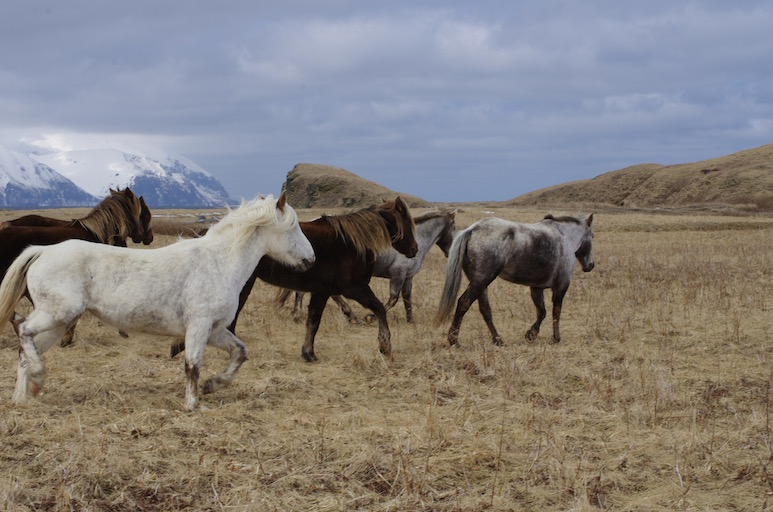

In [17]:
images_with_boxes = draw_boxes([img.copy()], boxes, scores, labels)
Image.fromarray(images_with_boxes[0])